> # **Configuration**


In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [ ]:
## Set The Path ##
%cd '/content/mydrive/MyDrive/MRI_Missing_Modality'

/content/mydrive/.shortcut-targets-by-id/1u1pCs1kaQnF4IoCddl0Yyil3Tjg83D1b/MRI_Missing_Modality


In [ ]:
!pip install MedPy
!pip install nilearn==0.1.4.post1

In [ ]:
import numpy as np
import os
import h5py

import nilearn as nl
import nibabel as nib

import torch, cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

> # **Load dataset (BraTS2020)**

In [ ]:
# !kaggle datasets download awsaf49/brats2020-training-data

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
100% 6.75G/6.76G [01:12<00:00, 106MB/s]
100% 6.76G/6.76G [01:12<00:00, 99.6MB/s]


In [ ]:
# !unzip brats2020-training-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: BraTS2020_training_data/content/data/volume_70_slice_63.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_64.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_65.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_66.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_67.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_68.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_69.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_7.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_70.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_71.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_72.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_slice_73.h5  
  inflating: BraTS2020_training_data/content/data/volume_70_sl

In [29]:
from sklearn.model_selection import train_test_split

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

IMG_SIZE=128


# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)//2):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)

In [30]:
def normalize_images(images):
    max_value = np.max(images)
    if max_value == 0:
        print("Warning: Maximum value in image set is zero, skipping normalization.")
        return images  # در صورتی که ماکسیمم صفر است، نرمال‌سازی نکنید
    return np.clip(images / max_value, 0, 1)

class DataGenerator(Dataset):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Return the total number of slices across all volumes
        return len(self.list_IDs) * VOLUME_SLICES

    def __getitem__(self, index):
        # Get the case index and slice index from the overall index
        case_index = index // VOLUME_SLICES
        slice_index = index % VOLUME_SLICES

        case_id = self.list_IDs[case_index]
        X, Y = self.__data_generation(case_id, slice_index)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs) * VOLUME_SLICES)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, case_id, slice_index):
        'Generates data for one slice of a case'

        case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

        # Load different modalities
        flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
        t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()
        t2 = nib.load(os.path.join(case_path, f'{case_id}_t2.nii')).get_fdata()
        seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

        # Extract the correct slice (add VOLUME_START_AT to slice index)
        flair_slice = flair[:, :, slice_index + VOLUME_START_AT]
        t1_slice = t1[:, :, slice_index + VOLUME_START_AT]
        t2_slice = t2[:, :, slice_index + VOLUME_START_AT]
        seg_slice = seg[:, :, slice_index + VOLUME_START_AT]

        # Check for NaNs in the slices
        assert not np.isnan(flair_slice).any(), f"NaN detected in flair slice for case {case_id}, slice {slice_index}"
        assert not np.isnan(t1_slice).any(), f"NaN detected in t1 slice for case {case_id}, slice {slice_index}"
        assert not np.isnan(t2_slice).any(), f"NaN detected in t2 slice for case {case_id}, slice {slice_index}"
        assert not np.isnan(seg_slice).any(), f"NaN detected in segmentation slice for case {case_id}, slice {slice_index}"

        # Resize slices
        flair_slice = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))
        t1_slice = cv2.resize(t1_slice, (IMG_SIZE, IMG_SIZE))
        t2_slice = cv2.resize(t2_slice, (IMG_SIZE, IMG_SIZE))
        seg_slice = cv2.resize(seg_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        # Check for NaNs in the slices
        if np.isnan(flair_slice).any() or np.isnan(t1_slice).any() or np.isnan(t2_slice).any() or np.isnan(seg_slice).any():
            print(f"Skipping slice {slice_index} of case {case_id} due to NaN values")
            return None, None  # Skip this slice by returning None


        # Stack modalities into a single 3-channel image (flair, t1, t2)
        X = np.zeros((*self.dim, self.n_channels))
        X[:, :, 0] = flair_slice
        X[:, :, 1] = t1_slice
        X[:, :, 2] = t2_slice

        # Create a one-hot encoded mask for 3 segmentation classes
        Y = np.zeros((*self.dim, 3))
        Y[:, :, 0] = (seg_slice == 1)  # NECROTIC/CORE
        Y[:, :, 1] = (seg_slice == 2)  # NECROTIC/CORE
        Y[:, :, 2] = (seg_slice == 4)  # EDEMA

        # Check for NaNs after resizing and stacking
        assert not np.isnan(X).any(), f"NaN detected in input image after resizing for case {case_id}, slice {slice_index}"
        assert not np.isnan(Y).any(), f"NaN detected in segmentation mask after resizing for case {case_id}, slice {slice_index}"

        # Normalize the image data to range [0, 1]
        # X = X / np.max(X)
        X = normalize_images(X)

        # Convert to torch tensors
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        return X, Y



training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)

# Sample dataloaders
train_dataloader = DataLoader(training_generator, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valid_generator, batch_size=32, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(valid_generator, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

len(train_dataloader)

Training batch - Images shape: torch.Size([32, 128, 128, 3]) Masks shape: torch.Size([32, 128, 128, 3])
Validation batch - Images shape: torch.Size([32, 128, 128, 3]) Masks shape: torch.Size([32, 128, 128, 3])


460

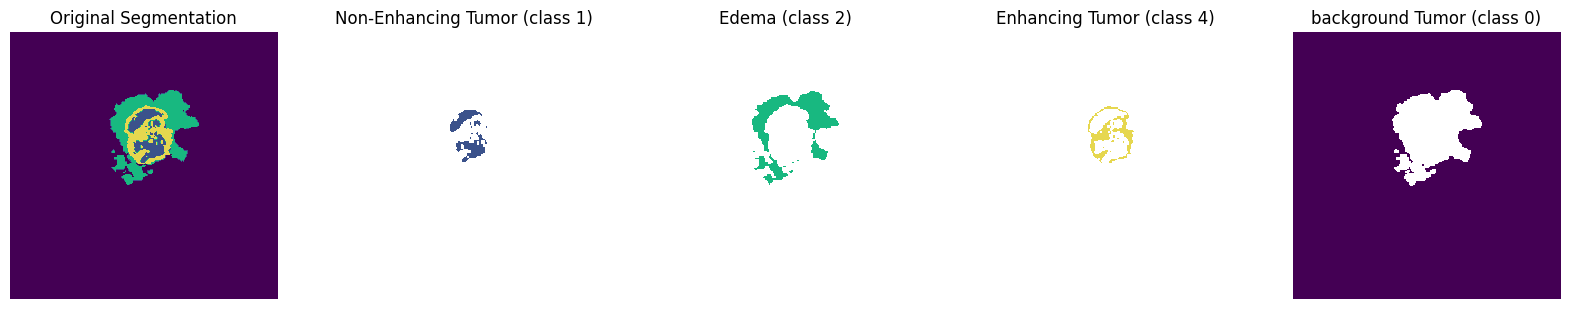

In [ ]:
x = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"
seg = nib.load(x).get_fdata()
seg = np.array(seg)

import matplotlib

# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

slice = 60

seg_0 = seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 1', 'class 2', 'class 4']

fig, ax = plt.subplots(1, 5, figsize=(20, 10))

ax[0].imshow(seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].axis('off')

ax[1].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Non-Enhancing Tumor (class 1)')
ax[1].axis('off')

ax[2].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Edema (class 2)')
ax[2].axis('off')

ax[3].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Enhancing Tumor (class 4)')
ax[3].axis('off')

ax[4].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('background Tumor (class 0)')
ax[4].axis('off')

plt.show()

(128, 128, 3)
[0. 1.]
0.0
1.0
[0. 1.]


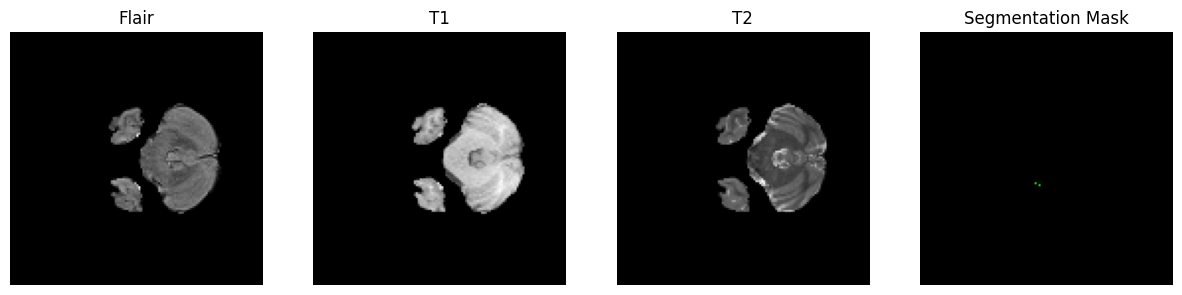

(128, 128, 3)
[0. 1.]
0.0
1.0
[0. 1.]


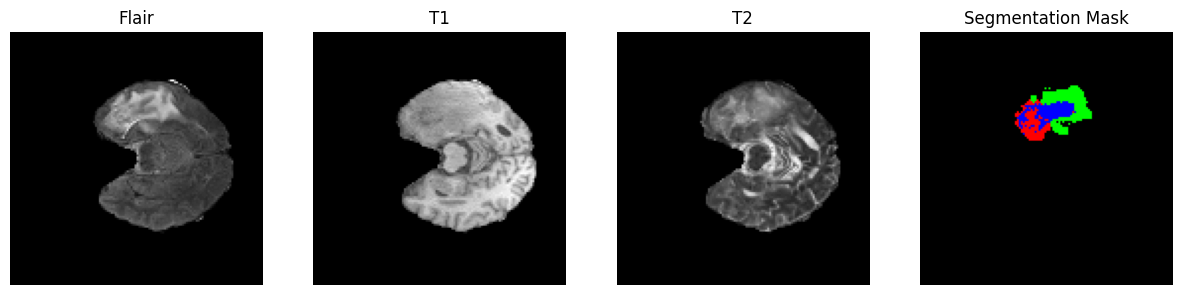

(128, 128, 3)
[0. 1.]
0.0
1.0
[0. 1.]


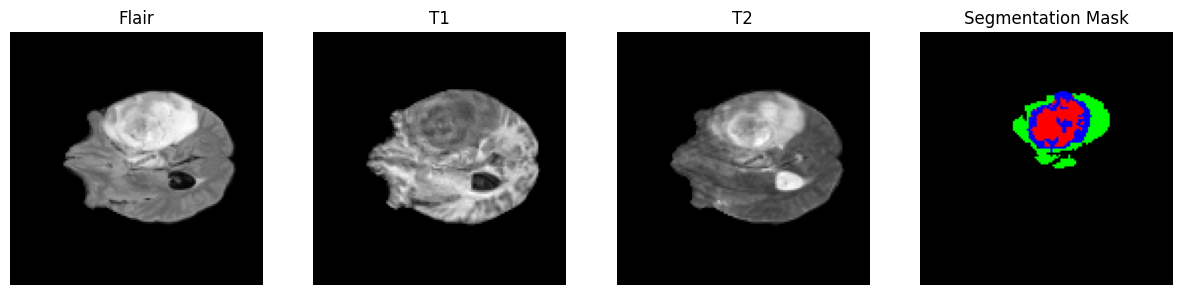

(128, 128, 3)
[0. 1.]
0.0
1.0
[0. 1.]


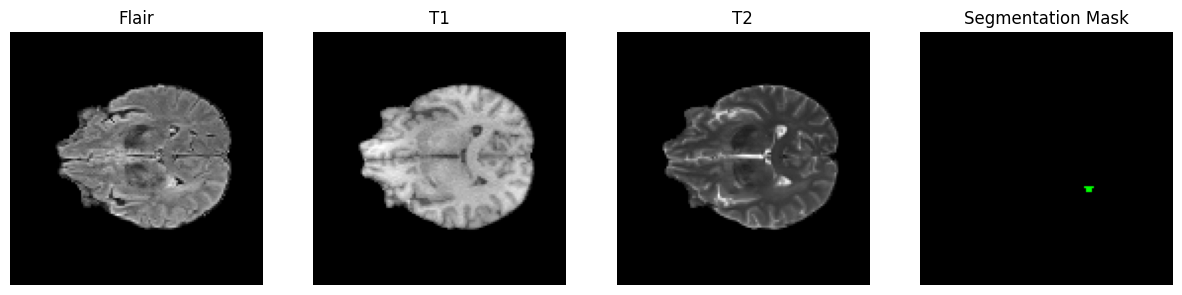

(128, 128, 3)
[0. 1.]
0.0
1.0
[0. 1.]


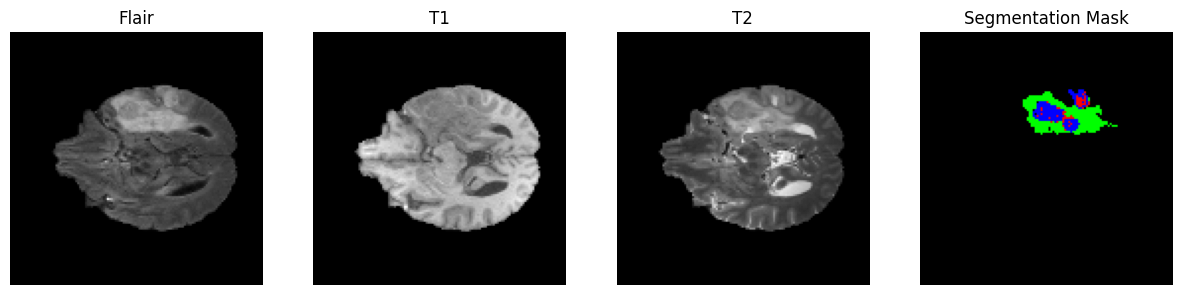

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a batch of images and masks
def visualize_val_samples(val_dataloader, num_samples=5):
    # Get a batch of validation data
    images, masks = next(iter(val_dataloader))

    # Plot the number of requested samples (or as many as available)
    for i in range(min(num_samples, len(images))):
        img = images[i].numpy()  # Convert tensor to numpy array
        mask = masks[i].numpy()  # Convert tensor to numpy array

        print(mask.shape)
        print(np.unique(mask))
        print(np.min(mask))
        print(np.max(mask))

        # Plot the three modalities (flair, t1, t2) and segmentation mask
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))

        # Flair image (first channel)
        ax[0].imshow(img[:, :, 0], cmap='gray')
        ax[0].set_title('Flair')
        ax[0].axis('off')  # Turn off axis

        # T1 image (second channel)
        ax[1].imshow(img[:, :, 1], cmap='gray')
        ax[1].set_title('T1')
        ax[1].axis('off')  # Turn off axis

        # T2 image (third channel)
        ax[2].imshow(img[:, :, 2], cmap='gray')
        ax[2].set_title('T2')
        ax[2].axis('off')  # Turn off axis

        # Segmentation mask (one-hot encoded to RGB-like display)
        # mask_display = np.argmax(mask, axis=-1) * 255  # Convert one-hot encoding to class labels
        print(np.unique(mask))
        ax[3].imshow(mask, cmap='viridis')  # Corrected to display the mask as labels
        ax[3].set_title('Segmentation Mask')
        ax[3].axis('off')  # Turn off axis

        plt.show()

# Visualize 5 validation samples
visualize_val_samples(train_dataloader, num_samples=5)

> # **Training**

> ### **Model Architecture**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def check_for_nan_inf(tensor, tensor_name):
    if tensor is None:
        return
    if torch.isnan(tensor).any():
        print(f"NaN detected in {tensor_name}")
    if torch.isinf(tensor).any():
        print(f"Inf detected in {tensor_name}")


class OctaveConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0, dilation=1,
                 groups=1, bias=False):
        super(OctaveConv, self).__init__()
        self.downsample = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        assert stride == 1 or stride == 2, "Stride should be 1 or 2."
        self.stride = stride
        assert 0 <= alpha_in <= 1 and 0 <= alpha_out <= 1, "Alphas should be in the interval from 0 to 1."
        self.alpha_in, self.alpha_out = alpha_in, alpha_out
        self.conv_l2l = None if alpha_in == 0 or alpha_out == 0 else \
                        nn.Conv2d(int(alpha_in * in_channels), int(alpha_out * out_channels),
                                  kernel_size, 1, padding, dilation, groups, bias)
        self.conv_l2h = None if alpha_in == 0 or alpha_out == 1 else \
                        nn.Conv2d(int(alpha_in * in_channels), out_channels - int(alpha_out * out_channels),
                                  kernel_size, 1, padding, dilation, groups, bias)
        self.conv_h2l = None if alpha_in == 1 or alpha_out == 0 else \
                        nn.Conv2d(in_channels - int(alpha_in * in_channels), int(alpha_out * out_channels),
                                  kernel_size, 1, padding, dilation, groups, bias)
        self.conv_h2h = None if alpha_in == 1 or alpha_out == 1 else \
                        nn.Conv2d(in_channels - int(alpha_in * in_channels), out_channels - int(alpha_out * out_channels),
                                  kernel_size, 1, padding, dilation, groups, bias)

        self.pc = PartialConv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        x_h, x_l = x if isinstance(x, tuple) else (x, None)
        check_for_nan_inf(x_h, "OctaveConv input x_h")
        check_for_nan_inf(x_l, "OctaveConv input x_l")

        if x_h is not None:
            x_h = self.downsample(x_h) if self.stride == 2 else x_h
            x_h2h = self.conv_h2h(self.pc(x_h))
            x_h2l = self.conv_h2l(self.downsample(self.pc(x_h))) if self.alpha_out > 0 else None
        if x_l is not None:
            x_l2h = self.conv_l2h(self.pc(x_l))
            x_l2h = self.upsample(x_l2h) if self.stride == 1 else x_l2h
            x_l2l = self.downsample(x_l) if self.stride == 2 else x_l
            x_l2l = self.conv_l2l(self.pc(x_l2l)) if self.alpha_out > 0 else None
            x_h2h = F.interpolate(x_h2h, (x_l2h.size()[2:]), mode='bilinear')
            x_h = x_l2h + x_h2h
            if x_h2l is not None:
                x_h2l = F.interpolate(x_h2l, (x_l2l.size()[2:]), mode='bilinear')
            x_l = x_h2l + x_l2l if x_h2l is not None and x_l2l is not None else None

        check_for_nan_inf(x_h, "OctaveConv output x_h")
        check_for_nan_inf(x_l, "OctaveConv output x_l")

        if x_l is not None:
            return x_h, x_l
        else:
            return x_h2h, x_h2l


class Conv_BN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(Conv_BN, self).__init__()
        self.conv = OctaveConv(in_channels, out_channels, kernel_size, alpha_in, alpha_out, stride, padding, dilation,
                               groups, bias)
        self.bn_h = None if alpha_out == 1 else norm_layer(int(out_channels * (1 - alpha_out)))
        self.bn_l = None if alpha_out == 0 else norm_layer(int(out_channels * alpha_out))

    def forward(self, x):
        x_h, x_l = self.conv(x)
        check_for_nan_inf(x_h, "Conv_BN input x_h")
        check_for_nan_inf(x_l, "Conv_BN input x_l")

        x_h = self.bn_h(x_h)
        x_l = self.bn_l(x_l) if x_l is not None else None

        check_for_nan_inf(x_h, "Conv_BN output x_h")
        check_for_nan_inf(x_l, "Conv_BN output x_l")
        return x_h, x_l


class Conv_BN_ACT(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU):
        super(Conv_BN_ACT, self).__init__()
        self.conv = OctaveConv(in_channels, out_channels, kernel_size, alpha_in, alpha_out, stride, padding, dilation,
                               groups, bias)

        self.bn_h = None if alpha_out == 1 else norm_layer(int(out_channels * (1 - alpha_out)))
        self.bn_l = None if alpha_out == 0 else norm_layer(int(out_channels * alpha_out))
        self.act = activation_layer(inplace=False)
        self.incc = in_channels
        self.outcc = out_channels
        self.ali = alpha_in
        self.alo = alpha_out

    def forward(self, x):
        x_h, x_l = self.conv(x)
        check_for_nan_inf(x_h, "Conv_BN_ACT input x_h")
        check_for_nan_inf(x_l, "Conv_BN_ACT input x_l")

        x_h = self.act(self.bn_h(x_h))
        x_l = self.act(self.bn_l(x_l)) if x_l is not None else None

        check_for_nan_inf(x_h, "Conv_BN_ACT output x_h")
        check_for_nan_inf(x_l, "Conv_BN_ACT output x_l")
        return x_h, x_l


class OctMaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__()
        self.maxpool_h = nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False,
                                      ceil_mode=False)
        self.maxpool_l = nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False,
                                      ceil_mode=False)

    def forward(self, x):
        h, l = x
        check_for_nan_inf(h, "OctMaxPool2d input h")
        check_for_nan_inf(l, "OctMaxPool2d input l")

        h_out = self.maxpool_h(h)
        l_out = self.maxpool_l(l)

        check_for_nan_inf(h_out, "OctMaxPool2d output h")
        check_for_nan_inf(l_out, "OctMaxPool2d output l")

        return h_out, l_out

class OctUp(nn.Module):
    def __init__(self, scale_factor=None, size=(None, None)):
        super().__init__()
        if scale_factor is not None:
            self.maxpool_h = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.maxpool_l = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.maxpool_h = nn.Upsample(size=size, mode='bilinear', align_corners=True)
            self.maxpool_l = nn.Upsample(size=size, mode='bilinear', align_corners=True)

    def forward(self, x):
        h, l = x
        check_for_nan_inf(h, "OctUp input h")
        check_for_nan_inf(l, "OctUp input l")

        h_out = self.maxpool_h(h)
        l_out = self.maxpool_l(l)

        check_for_nan_inf(h_out, "OctUp output h")
        check_for_nan_inf(l_out, "OctUp output l")

        return h_out, l_out


class OctUp_size(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        h, l = x1
        check_for_nan_inf(h, "OctUp_size input h")
        check_for_nan_inf(l, "OctUp_size input l")

        h_out = F.interpolate(h, x2[0].size()[2:], mode='bilinear')
        l_out = F.interpolate(l, x2[1].size()[2:], mode='bilinear')

        check_for_nan_inf(h_out, "OctUp_size output h")
        check_for_nan_inf(l_out, "OctUp_size output l")

        return h_out, l_out


class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0],
                                                 self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * \
                             self.weight_maskUpdater.shape[3]

        self.last_size = (None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask=None):
        check_for_nan_inf(input, "PartialConv2d input")
        if mask is not None or self.last_size != (input.data.shape[2], input.data.shape[3]):
            self.last_size = (input.data.shape[2], input.data.shape[3])

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2],
                                          input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride,
                                            padding=self.padding, dilation=self.dilation, groups=1)

                self.mask_ratio = self.slide_winsize / (self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)

        if self.update_mask.type() != input.type() or self.mask_ratio.type() != input.type():
            self.update_mask = self.update_mask.to(input)
            self.mask_ratio = self.mask_ratio.to(input)
        if mask is not None:
            input = torch.mul(input, mask)

        check_for_nan_inf(input, "PartialConv2d output")
        return input

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from octconv import *

class SCSEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_excitation = nn.Sequential(nn.Linear(channel, int(channel // reduction)),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(int(channel // reduction), channel))
        self.spatial_se = nn.Conv2d(channel, 1, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        bahs, chs, _, _ = x.size()

        chn_se = self.avg_pool(x).view(bahs, chs)
        chn_se = torch.sigmoid(self.channel_excitation(chn_se).view(bahs, chs, 1, 1))
        chn_se = torch.mul(x, chn_se)
        spa_se = torch.sigmoid(self.spatial_se(x))
        spa_se = torch.mul(x, spa_se)
        return torch.add(chn_se, spa_se, alpha=1)


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch, stride=1, downsample=None, groups=1,
                 base_width=64, alpha_in=0.5, alpha_out=0.5, norm_layer=None, output=False):
        super(double_conv, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv = nn.Sequential(

            Conv_BN_ACT(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, groups=groups, norm_layer=norm_layer,
                        alpha_in=0 if output else 0.5, alpha_out=0 if output else 0.5),
            Conv_BN_ACT(out_ch, out_ch, kernel_size=3, stride=stride, padding=1, groups=groups, norm_layer=norm_layer,
                        alpha_in=0 if output else 0.5, alpha_out=0 if output else 0.5),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, alpha_in=0.5, alpha_out=0.5, norm_layer=None, output=False):
        super(inconv, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv = nn.Sequential(
            nn.Conv2d(inplanes, planes, 3, padding=1),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            Conv_BN_ACT(planes, width, kernel_size=3, alpha_in=0.5 if output else 0, alpha_out=alpha_out, norm_layer=norm_layer)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, downsample=None, groups=1,
                 base_width=64, alpha_in=0.5, alpha_out=0.5, norm_layer=None, output=False):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            OctMaxPool2d(2),
            double_conv(in_ch, out_ch, stride=1, downsample=None, groups=1,
                        base_width=64, alpha_in=0.5, alpha_out=0.5, norm_layer=None, output=False)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = OctUp(scale_factor=2, size=(None, None))
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)
        self.SCSE = SCSEBlock(int(out_ch/2))
        self.upsize = OctUp_size()

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.upsize(x1, x2)
        x_h = torch.cat([x2[0], x1[0]], dim=1)
        x_l = torch.cat([x2[1], x1[1]], dim=1)
        x = (x_h, x_l)
        x = self.conv(x)
        x_h = self.SCSE(x[0])
        x_l = self.SCSE(x[1])
        return (x_h, x_l)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = OctaveConv(in_ch, out_ch, kernel_size=1, alpha_in=0.5, alpha_out=0)

    def forward(self, x):
        x = self.conv(x)
        return x


class OctaveUNet(nn.Module):
    def __init__(self, n_classes, in_ch=3):
        super(OctaveUNet, self).__init__()
        self.inc = inconv(in_ch, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)  # n_classes for multi-class output

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)
        x10 = self.outc(x9)

        # Interpolate to match input size, if necessary
        out = F.interpolate(x10[0], (x.size(2), x.size(3)))

        # Apply softmax for multi-class segmentation
        # out = F.softmax(out, dim=1)  # Softmax over channel dimension for multi-class output
        return out

In [ ]:
# Function that saves a model to specified path
def save_model(model, path='weights/model_weights.pth'):
    torch.save(model.state_dict(), path)

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot training and validation losses
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    ax1.plot([np.NaN] + val_epoch_losses, color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    ax1.set_ylim(0, 1)  # Set limits for loss
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Title and formatting
    plt.title('Training & Validation Loss, Dice Score, and Hausdorff Distance Over Epochs', fontsize=16)

    plt.savefig('Unet_Training_Validation_Loss.png')
    fig.tight_layout()  # Ensures no overlap between axes
    plt.show()

> ### **Traning process**

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os

# Assuming DataGenerator and OctaveUNet are already defined

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move to device
model = OctaveUNet(n_classes=3).to(device)
batches_per_epoch = 64

# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class segmentation
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training and validation loop
num_epochs = 30

def train_one_epoch(epoch, model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0, 3, 1, 2)  # Change image dimensions to [B, C, H, W]
        masks = masks.permute(0, 3, 1, 2)  # Change image dimensions to [B, C, H, W]

        # Convert masks from one-hot or continuous to integer class labels
        # if masks.dtype != torch.long:
            # masks = masks.argmax(dim=1)  # Assuming the masks are one-hot, convert to class indices

        # Forward pass
        outputs = model(images)

        # CrossEntropyLoss expects masks as class indices, not one-hot encoded
        loss = criterion(outputs, masks)  # Ensure masks are of type Long for CrossEntropyLoss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # if i % 50 == 0:
            # print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        if i >= batches_per_epoch:
            if print()
            return running_loss / batches_per_epoch



def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0, 3, 1, 2)
            masks = masks.permute(0, 3, 1, 2)  # Change image dimensions to [B, C, H, W]

            # Convert masks from one-hot or continuous to integer class labels
            # if masks.dtype != torch.long:
                # masks = masks.argmax(dim=1)

            outputs = model(images)

            loss = criterion(outputs, masks)  # Ensure masks are of type Long for CrossEntropyLoss

            val_loss += loss.item()

            if i >= batches_per_epoch:
                if print()
                return val_loss / batches_per_epoch


train_epoch_losses = []
val_epoch_losses = []

# Initialize best validation loss
best_val_loss = float('inf')
best_model_path = 'weights/unet_best.pth'

# Create directory to save weights if it doesn't exist
if not os.path.exists('weights'):
    os.makedirs('weights')

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(epoch, model, train_dataloader, criterion, optimizer)
    val_loss = validate_one_epoch(model, val_dataloader, criterion)
    train_epoch_losses.append(train_loss)
    val_epoch_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Save final model
torch.save(model.state_dict(), 'weights/unet_final.pth')

# Assuming `plot_learning_curves` is defined elsewhere
plot_learning_curves(train_epoch_losses, val_epoch_losses)

> # **Showing the result**

In [31]:
import matplotlib.pyplot as plt
import torch, os, numpy as np
import cv2, os, h5py, torch

plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :] * 255, mask[1, :, :] * 255, mask[2, :, :] * 255], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

In [32]:
# model = AttentionUNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = OctaveUNet(n_classes=3).to(device)

In [33]:
# model.load_state_dict(torch.load('weights/attention-unet-weights.pth', weights_only=False, map_location=torch.device(device)))
model.load_state_dict(torch.load('weights/unet_best.pth', weights_only=False, map_location=torch.device(device)))

# test_input, test_target = test_input.to(device), test_target.to(device)

# Obtain the model's prediction
# test_pred = model(image.to(device))

<All keys matched successfully>

In [34]:
images, masks = next(iter(train_dataloader))

In [35]:
pred = model(images.permute(0, 3, 1, 2).to(device))
pred.shape

torch.Size([32, 3, 128, 128])

In [36]:
def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.float32)
        rgb_mask[..., idx] = mask[idx, :, :] * 255 # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

[-14.999148  -14.880991  -14.821136  ...   4.6276054   4.643745
   4.7857995]
[0. 1.]


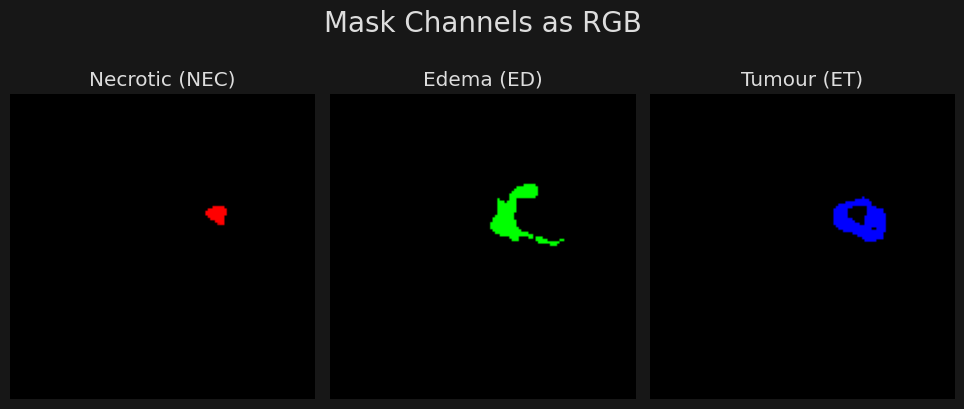

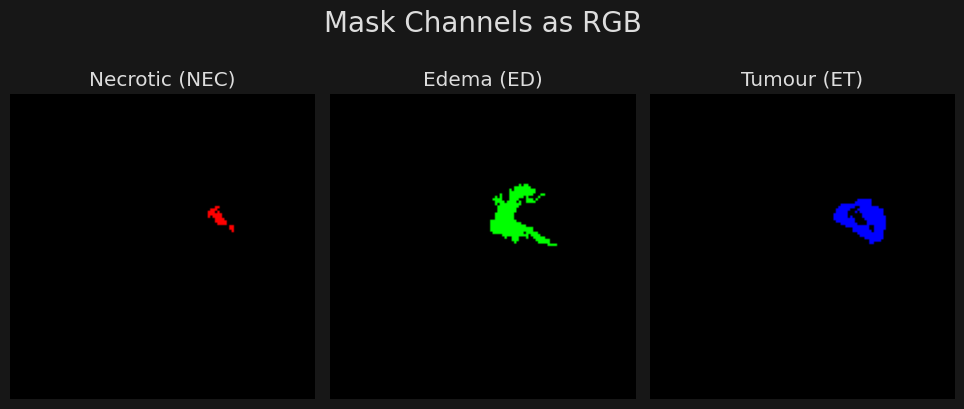

In [38]:
idx = 3

predicted_mask = pred[idx].detach().cpu().numpy()
print(np.unique(predicted_mask))
mask = masks[idx].detach().cpu().numpy()
print(np.unique(mask))

display_mask_channels_as_rgb(predicted_mask)
display_mask_channels_as_rgb(mask.transpose(2, 0, 1))

In [39]:
image = images[idx]

In [40]:
image.shape

torch.Size([128, 128, 3])

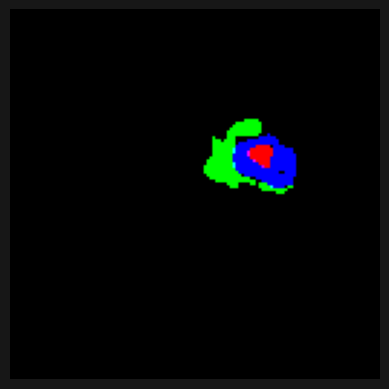

In [52]:
rgb_mask = np.zeros((predicted_mask.shape[1], predicted_mask.shape[2], 3), dtype=np.float32)

for i in range(predicted_mask.shape[0]):
    rgb_mask[..., i] = predicted_mask[i, :, :] * 255
    plt.imshow(rgb_mask)

plt.axis('off')
plt.show()